In [1]:
import nbimporter
import numpy as np
import matplotlib.pyplot as plt

import gas_water
import liquid_water
import solid_material

import flux
import balance_equation as be
import property_conversion  as prop
import moisture_conversion as mc
import lewis_relation as lewis

Importing Jupyter notebook from gas_water.ipynb
Importing Jupyter notebook from moisture_conversion.ipynb
Importing Jupyter notebook from vapour_pressure.ipynb
Importing Jupyter notebook from liquid_water.ipynb
Importing Jupyter notebook from property_conversion.ipynb
Importing Jupyter notebook from solid_material.ipynb
Importing Jupyter notebook from flux.ipynb
Importing Jupyter notebook from balance_equation.ipynb
Importing Jupyter notebook from Lewis_relation.ipynb


# 1次元モデルの差分計算をするためのモジュール  


## 1. 壁体の分割

### クラス：Cell( i )  
差分法におけるコントロールボリューム（CV）に相当する構造体。  
固相・液相・気相に関する各モジュール、およびCVの大きさ、位置、CV当たりに対する物性情報などを有する。  
一般には示量変数はCellクラスそのものが保持し、示強変数はモジュール単位で管理することとする。  

- cellクラス  
    i：セルの位置    
    dx：セルの大きさ    
    
    - 熱・水分・物質移動係数
        各種移動係数は後述のcellの構成情報に影響を受けるためcellクラスが保有する

- 気相情報(Gas)  
    - 水蒸気(gas_water)  
        temp：温度[K]  
        rh：相対湿度[-]  
        miu：水分化学ポテンシャル[J/kg]  
        pv：水蒸気圧[Pa]  
    - 空気（未実装）


- 液相情報(Liquid)  
    - 純水(liquid_water)  
        temp：温度[K]  
        miu：水分化学ポテンシャル[J/kg]  
        phi：含水率[-]  
        pl：水圧[Pa]  
    - 塩溶液（未実装）  
        

- 固相情報(Solid)  
    - 材料骨格部(solid_material)  
        material：材料の名称  
        crow：材料骨格部の熱容量（比熱×密度）  
    - 氷（未実装）   
    - 塩（未実装）  

- Cellクラスが保有する物性情報
    - crow：CVの熱容量（固相＋液相）
    - lam：熱伝達率  
    - ldp：透湿率  
    - ldml：水分化学ポテンシャル勾配に対する液相水分伝導率  


※　materialクラスに材料名を入力後、必ずwaterクラスに材料名を入れること　⇒　平衡含水率が出せなくなる

In [2]:
class Cell():
    def __init__( self, i ):
        self.position = i
    
    # cell information
    # Length of cell
    def set_dx( self, initial = 0.0 ):
        self.dx = initial 
    
    # Gas condition（気相）
    def set_Gas_Water_BasedMiu( self, temp = 0.0, miu = 0.0 ):
        self.vapour = gas_water.MiuBasedMoisture( temp, miu )
        
    def set_Gas_Water_BasedRH( self, temp = 0.0, rh = 0.0 ):
        self.vapour = gas_water.RHBasedMoisture( temp, rh )
        
    def set_Gas_Water_BasedPV( self, temp = 0.0, pv = 0.0 ):
        self.vapour = gas_water.PVBasedMoisture( temp, pv )
        
    # Liquid condition（液相）
    def set_Liquid_Water_BasedMiu( self, temp = 0.0, miu = 0.0 ):
        self.water = liquid_water.MiuBasedWater( temp, miu )
        
    def set_Liquid_Water_BasedPhi( self, temp = 0.0, phi = 0.0 ):
        self.water = liquid_water.PhiBasedWater( temp, phi )
        
    # Solid condition（固相）
    def set_Solid_Material( self, temp, material_name ):
        self.material = solid_material.TempBased( temp, material_name )
        
    # Transfer coefficient（セルの有する移動係数）        
    # lam 熱伝導率
    def get_lam(self):
        return prop.Kernel_TransferCoefficient( self.material.name ).getLAM( self.water )
    
    lam = property(get_lam)
        
    # dp 湿気伝導率
    def get_dp(self):
        return prop.Kernel_TransferCoefficient( self.material.name ).getDP( self.water )
    
    dp = property(get_dp)
        
    # ldml 液水の水分伝導率
    def get_ldml(self):
        return prop.Kernel_TransferCoefficient( self.material.name ).getLDML( self.water )

    ldml = property(get_ldml)
    
    
    #############################################################
    # 3相の局所平衡が成り立っている場合における一括設定  
    # cellの大きさ・温度・相対湿度・材料名の一括設定（初期設定）
    def set_all( self, dx, temp, rh, material_name ):
        self.dx = dx
        self.vapour = gas_water.RHBasedMoisture( temp, rh )
        self.water = liquid_water.MiuBasedWater( temp, self.vapour.miu )
        self.material = solid_material.TempBased( temp, material_name )
        self.water.set_material( material_name ) 
    
    # 温度の一括設定
    def set_temp( self, temp ):
        self.vapour.set_temp(temp)
        self.water.set_temp(temp)
        self.material.set_temp(temp)
        
    # 水分化学ポテンシャルの一括設定
    def set_miu( self, miu ):
        self.water.set_miu( miu )
        self.vapour.set_miu( miu )
    
    # 含水率の一括設定
    def set_phi( self, phi ):
        self.water.set_phi( phi )
        self.vapour.set_miu( self.water.miu )
        
    # 水蒸気圧の一括設定
    def set_pv( self, pv ):
        self.vapour.set_pv( pv )
        self.water.set_miu( self.vapour.miu )
    

### 使用例

セルの個数を決定する

In [3]:
number = 5

セルの作成・大きさを与える

In [4]:
wall = [ Cell(i) for i in range(number)]
[ cell.set_dx(0.1) for cell in wall ]

[None, None, None, None, None]

水蒸気の情報（温度20℃、相対湿度60%）を与える

In [5]:
[ cell.set_Gas_Water_BasedRH( temp = 293.15, rh = 0.6 ) for cell in wall ]

[None, None, None, None, None]

材料情報を与える

In [6]:
[ cell.set_Solid_Material( temp = cell.vapour.temp, material_name = 'BentheimerSandstone' ) for cell in wall ]

[None, None, None, None, None]

水蒸気・材料の情報から液水の情報を算出する

In [7]:
[ cell.set_Liquid_Water_BasedMiu( temp = cell.vapour.temp, miu = cell.vapour.miu ) for cell in wall ]
[ cell.water.set_material( material_name = cell.material.name ) for cell in wall ]

[None, None, None, None, None]

#### 値の確認
セル情報の構築は以上となる。セル情報をいくつか引き出しみる。  
例えば液水の含水率は

In [8]:
wall[1].water.phi

Importing Jupyter notebook from bentheimer_sandstone.ipynb
Importing Jupyter notebook from van_genuchten.ipynb


3.2608830802176583e-05

セルの液相水分伝導率は

In [9]:
wall[1].ldml

2.4529155342643628e-23

### クラス：Air( i )  
材料境界などに位置する室空気のクラス。  
Cellクラスと基本概念は同じであるが固相・液相情報は持たず気相情報のみを持つものとする。  
また、Cellクラス同様に空間の容積などの示量変数はAirクラスに内包され、示強変数はそれぞれの相情報に保持される。  
現状、室空気は温度と水分情報しか持たないことが多いため、gas_waterのクラスのみを用いることで代用した。

- Air情報     
    i : Airの名称（基本的には何でもよい）  
    vol：Airの容積[m3]
    
    
    - 熱・水分・物質伝達係数

- 気相情報(Gas)  
    - 水蒸気(gas_water)  
        temp：温度[K]  
        rh：相対湿度[-]  
        miu：水分化学ポテンシャル[J/kg]  
        pv：水蒸気圧[Pa]  
    - 空気（未実装）


In [10]:
class  Air():
    def __init__( self, i ):
        self.position = i
    
    # cell information
    # Length of cell
    def set_volume( self, volume = 0.0 ):
        self.vol = volume 
    
    # Gas condition（気相）
    def set_Air_BasedMiu( self, temp = 0.0, miu = 0.0 ):
        self.air = gas_water.MiuBasedMoisture( temp, miu )
        
    def set_Air_BasedRH( self, temp = 0.0, rh = 0.0 ):
        self.air = gas_water.RHBasedMoisture( temp, rh )
        
    def set_Air_BasedPV( self, temp = 0.0, pv = 0.0 ):
        self.air = gas_water.PVBasedMoisture( temp, pv )
        
    # Transfer coefficient（セルの有する移動係数）
    def set_HeatTransferCoefficient( self, alpha ):
        self.alpha = alpha
        
    def set_MoistureTransferCoefficient( self, aldm ):
        self.aldm = aldm
        
    # Lewis関係による湿気伝達率のセット（対流熱伝達率を入力すること）
    def set_MoistureTransferCoefficient_byLewis( self, alpha ):
        self.aldm = lewis.cal_aldm( alpha, self.air.temp )
        

### 使用例
基本はCellクラスと同じなので

In [11]:
# 使用例
situ = Air('室空気')

In [12]:
situ.set_volume(100.0)
situ.set_Air_BasedRH( temp = 283.15, rh = 0.8 ) 
situ.set_HeatTransferCoefficient( alpha = 9.3 )
situ.set_MoistureTransferCoefficient( aldm = lewis.cal_aldm( alpha = 9.3, temp = 283.15 ) )

#### 値の確認

In [13]:
situ.aldm

6.363481352179196e-08

## 2. 流量計算  

### 2.1 材料内の計算
壁体内部における流量の計算を行う。  
wallの端から端までの熱流計算は、

In [14]:
qs = [ flux.cal_heat_conduction_byCell(wall[i], wall[i+1]) for i in range(len(wall)-1)] 

同様に水蒸気流、液水の計算結果は、

In [15]:
jv = [ flux.cal_vapour_permeance_pressure_byCell(wall[i], wall[i+1], 1.0) for i in range(len(wall)-1)] 
jl = [ flux.cal_liquid_conduction_potential_byCell(wall[i], wall[i+1], 1.0) for i in range(len(wall)-1)] 

### 2.2 境界における計算

次に材料境界における計算を行う。

材料端部（0側）の熱流は、

In [16]:
qs.insert( 0, flux.cal_heat_transfer_byCell( cell_mns = situ, cell_pls = wall[0] ) )

材料端部（終端側）の熱流は、

In [17]:
qs.insert( len(qs),flux.cal_heat_transfer_byCell( cell_mns = wall[len(wall)-1], cell_pls = situ ) )

同様に水蒸気流、液相水分流は、

In [18]:
jv.insert( 0, flux.cal_vapour_transfer_pressure_byCell( cell_mns = situ, cell_pls = wall[0], nx_dir = 1.0 ) )
jv.insert( len(jv), flux.cal_vapour_transfer_pressure_byCell( cell_mns = wall[len(wall)-1], cell_pls = situ, nx_dir = 1.0 ) )
jl.insert( 0, 0.0 )
jl.insert( len(jl), 0.0 )

## 3. 熱・水分の収支計算

収支計算モジュールはcellとcell両端に流出入するflux、時間刻みdtを入力することで計算できる。  
ここでは上述のwall1とflux3を使うことで以下のように計算する。  
まずはwall1の表面[1]について

時間刻みは、

In [19]:
dt = 0.1

熱収支式は、

In [20]:
ntemp = [ be.cal_newtemp_byCell(cell = wall[i], qs_mns = qs[i], qs_pls = qs[i+1],\
                                jv_mns = jv[i], jv_pls = jv[i+1], time = dt ) for i in range(len(wall)) ]

水分収支式は、

In [21]:
nmiu = [ be.cal_newmiu_byCell(cell = wall[i], jv_mns = jv[i], jv_pls = jv[i+1],\
                              jl_mns = jv[i], jl_pls = jv[i+1], time = dt ) for i in range(len(wall)) ]

#### 値の確認  
温度の計算結果は、

In [22]:
print(ntemp)

[293.14993608875534, 293.15, 293.15, 293.15, 293.14993608875534]


水分化学ポテンシャルは、

In [23]:
print(nmiu)

[-69129.09393456156, -69122.37948733423, -69122.37948733423, -69122.37948733423, -69129.09393456156]


ここまでが熱・水分の計算を行う一連の流れである。  
この後は流量計算から収支計算までの流れをループ計算すればよい。  
ただし現段階では計算の発散や振動を検知するエラーチェックプログラムは未実装である。

## 4. Cellクラスへの値の再セット  
熱・水分の収支計算の結果を確認した後、Cellクラスに新値をセットする必要がある。  
この工程は省略し、上述の収支計算をntempやnmiuとして保持せずそのままセットしても良い。

温度のセット

In [24]:
[ wall[i].set_temp(ntemp[i]) for i in range(len(wall)) ]

[None, None, None, None, None]

水分化学ポテンシャルのセット

In [25]:
[ wall[i].set_miu(nmiu[i]) for i in range(len(wall)) ]

[None, None, None, None, None]

## 5. 一連の流れのまとめ  
一連の流れを関数でまとめてみる。

In [26]:
def calculation( air_in, wall, air_out, nx, dt ):
    # 熱流計算
    qs = [ flux.cal_heat_conduction_byCell(wall[i], wall[i+1]) for i in range(len(wall)-1)]     
    qs.insert( 0, flux.cal_heat_transfer_byCell( cell_mns = air_in, cell_pls = wall[0] ) )
    qs.insert( len(qs),flux.cal_heat_transfer_byCell( cell_mns = wall[len(wall)-1], cell_pls = air_out ) )

    # 水蒸気流計算
    jv = [ flux.cal_vapour_permeance_pressure_byCell(wall[i], wall[i+1], nx) for i in range(len(wall)-1)] 
    jv.insert( 0, flux.cal_vapour_transfer_pressure_byCell( cell_mns = air_in, cell_pls = wall[0], nx_dir = nx ) )
    jv.insert( len(jv), flux.cal_vapour_transfer_pressure_byCell( cell_mns = wall[len(wall)-1], cell_pls = air_out, nx_dir = nx ) )
    
    # 液水流計算
    jl = [ flux.cal_liquid_conduction_potential_byCell(wall[i], wall[i+1], nx) for i in range(len(wall)-1)] 
    jl.insert( 0, 0.0 )
    jl.insert( len(jl), 0.0 )
    
    # 熱・水分収支式
    ntemp = [ be.cal_newtemp_byCell(cell = wall[i], qs_mns = qs[i], qs_pls = qs[i+1],\
                                    jv_mns = jv[i], jv_pls = jv[i+1], time = dt ) for i in range(len(wall)) ]
    nmiu = [ be.cal_newmiu_byCell(cell = wall[i], jv_mns = jv[i], jv_pls = jv[i+1],\
                                  jl_mns = jv[i], jl_pls = jv[i+1], time = dt ) for i in range(len(wall)) ]
    
    # 値の入れ替え
    [ wall[i].set_temp(ntemp[i]) for i in range(len(wall)) ]
    [ wall[i].set_miu(nmiu[i]) for i in range(len(wall)) ]

## 実際の使用例

壁体の分割数、初期条件、材料情報を入力する。  
- 分割数：10  
- cellの大きさ：10mm  
- 初期温度：20℃  
- 初期相対湿度：60%  
- 材料：'Sandstone'  
としてみる

In [27]:
number = 10
wall = [ Cell(i) for i in range(10)]
[ cell.set_all( dx = 0.01, temp = 293.15, rh = 0.6, material_name = 'BentheimerSandstone' ) for cell in wall ]

[None, None, None, None, None, None, None, None, None, None]

室内側境界のセット  
- 名称：室空気  
- 温度：17℃  
- 相対湿度：60%  
- 総合熱伝達率：9.3（うち対流熱伝達率9.3）

In [28]:
inner_air = Air('室空気')
inner_air.set_Air_BasedRH( temp = 290.15, rh = 0.6 ) 
inner_air.set_HeatTransferCoefficient( alpha = 9.3 )
inner_air.set_MoistureTransferCoefficient_byLewis( alpha = 4.9 )

外気側境界のセット  
- 名称：外気  
- 温度：30℃  
- 相対湿度：70%  
- 総合熱伝達率：23.3（うち対流熱伝達率19.0）

In [29]:
outer_air = Air('外気')
outer_air.set_Air_BasedRH( temp = 303.15, rh = 0.7 ) 
outer_air.set_HeatTransferCoefficient( alpha = 23.3 )
outer_air.set_MoistureTransferCoefficient_byLewis( alpha = 19.0 )

計算方向（重力方向に対する応答）、計算刻みのセット

In [30]:
dt = 1.0
nx = 0.0

ループ計算

In [37]:
for i in range(500):
    calculation( inner_air, wall, outer_air, nx, dt )

### グラフの描画

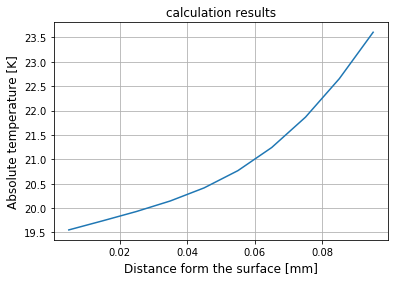

In [38]:
# Data for plotting
x = [ cell.position * cell.dx + cell.dx / 2.0 for cell in wall ]
y = [ cell.vapour.temp - 273.15 for cell in wall ]

fig, ax = plt.subplots()
ax.plot(x, y)

#ax.set_xticks([ n * 10 + 273.15 for n in range(0, 6) ])
#ax.set_yticks([ n * 2000 for n in range(0, 7) ])
ax.set_xlabel('Distance form the surface [mm]', fontsize = 12 )
ax.set_ylabel('Absolute temperature [K]', fontsize = 12 )
ax.set_title( 'calculation results', fontsize = 12 )

ax.grid()
#fig.savefig("test.png")
plt.show()